In [ ]:
import numpy as np
import pandas as pd

class FXTrading:
    def __init__(self, fx_rates, real_fx_rates):
        """
        Initialize the FXTrading simulation environment.

        Args:
            fx_rates (numpy array): Predicted FX rates (3, N)
            real_fx_rates (numpy array): Real FX rates (3, N)
        """
        self.Pre_fx_rates = fx_rates
        self.real_fx_rates = real_fx_rates
        self.day = 0
        self.start = len(fx_rates[0]) - 1  # Starting point in the time series

        self.initial_capital = np.array([1000, 1000, 1000], dtype=float)  # 「三種貨幣交易帳戶的初始資金」各為 $1000(Initial capital for 3 currencies)
        self.capital = np.array([1000, 1000, 1000], dtype=float)  # 當前資金(Current capital)
        self.available_margin = self.capital  # 可動用的保證金額度(Available margin)

        self.leverage = np.array([5, 5, 5])  # Leverage for each currency (can be changed when opening positions)
        self.position_size = np.array([0, 0, 0], dtype=float)  # 三種貨幣目前的持倉數量（張數/單位）Current position size (positive=long, negative=short)
        self.position_value = np.array([0, 0, 0], dtype=float)  # 三種貨幣當前持倉的總市值（含槓桿）Current position value
        self.floating_pnl = np.array([0, 0, 0], dtype=float)  # 因為市場價格波動而產生的帳面盈虧(Current floating profit and loss)
        self.now_price = np.array([
            real_fx_rates[0][self.start],
            real_fx_rates[1][self.start],
            real_fx_rates[2][self.start]
        ], dtype=float)  # Current market price
        self.entry_price = np.array([0, 0, 0], dtype=float)  # 進場價格（建倉時的價格）(Entry price of the current position)
        self.margin = 10  # 每單位倉位需要的初始保證金(Margin required per position)

        self.model = None  # Placeholder for custom prediction model

    # 確認是否需要強制平倉
    def check_liquidation(self, cap_num, maintenance_margin_ratio_threshold=0.3):
        """
        Check if the position should be liquidated (trigger forced liquidation).

        Args:
            cap_num (int): Index of the currency (0, 1, 2)
            maintenance_margin_ratio_threshold (float): Liquidation threshold (default 30%)

        Returns:
            bool: True if should liquidate, False otherwise
        """
        equity = self.capital[cap_num] + self.floating_pnl[cap_num] # ex : 2500 = 3000 + (-500)

        if equity / (self.margin * abs(self.position_size[cap_num])) < maintenance_margin_ratio_threshold:
            return True

        return False
    
    # 平倉一筆倉位，並計算其實現損益（Realized PnL）
    def close_position(self, cap_num, close_price):
        """
        Close the position and calculate realized PnL.

        Args:
            cap_num (int): Index of the currency
            close_price (float): Current market price

        Returns:
            float: Realized PnL(非浮動損益)
        """
        return (close_price - self.entry_price[cap_num]) * self.position_size[cap_num] * self.margin * self.leverage[cap_num] / close_price

    def predict_fx_rate(self, data): #Needs to be designed manually
        """
        Predict the next FX rate. User should implement their own model.

        Args:
            data (any): Input features for prediction.

        Returns:
            None: Updates self.Pre_fx_rates
        """
        # Random prediction example:
        a = np.random.choice(self.Pre_fx_rates[0])
        b = np.random.choice(self.Pre_fx_rates[1])
        c = np.random.choice(self.Pre_fx_rates[2])
        fx_rate = np.array([[a], [b], [c]])

        # Update Pre_fx_rates by appending new prediction
        self.Pre_fx_rates = np.concatenate([self.Pre_fx_rates, fx_rate], axis=1)

    def open_position(self, cap_num, any): #Needs to be designed manually
        """
        Decide how to open a position.

        Args:
            cap_num (int): Index of the currency

        Returns:
            (int, float): (action, number of lots)
                action: 0 = LONG, 1 = SHORT, 2 = HOLD
                buy_num: number of lots
        """
        action = 1
        buy_num = 10

        return action, buy_num

    def decide_action(self, any): #Needs to be designed manually
        """
        Decide what to do with an existing position.

        Returns:
            (int, float): (action, number of lots)
                action: 0 = ADD, 1 = CLOSE, 2 = HOLD
        """
        action = 2
        buy_num = 1

        return action, buy_num

    def update_entry_price(self, cap_num, add_price, old_position, add_position):
        """
        Update the average entry price after adding position.

        Args:
            cap_num (int): Index of the currency
            add_price (float): Price of new added position
            old_position (float): Previous position size
            add_position (float): New added position size
        """
        old_value = abs(old_position) * self.margin * self.leverage[cap_num]
        add_value = abs(add_position) * self.margin * self.leverage[cap_num]

        self.entry_price[cap_num] = (self.entry_price[cap_num] * old_value + add_price * add_value) / (old_value + add_value)

    def update(self):
        """
        Update environment for current day (prices, margins, PnL, position value).
        """
        self.now_price = np.array([
            self.real_fx_rates[0][self.start + self.day],
            self.real_fx_rates[1][self.start + self.day],
            self.real_fx_rates[2][self.start + self.day]
        ])

        self.available_margin = self.capital - abs(self.position_size) * self.margin
        self.position_value = abs(self.margin * self.position_size * self.leverage)
        self.floating_pnl = self.position_size * (self.now_price - self.entry_price) * self.leverage * self.margin / self.now_price

    def run_days(self, max_days=None):
        """
        Run simulation over multiple days.

        Args:
            max_days (int): Number of days to run
        """
        for day in range(max_days):
            self.day = day
            self.update()
            self.predict_fx_rate(None) #

            # Print current state
            print("Day ", day + 1)
            print(" ")

            for i, name in enumerate(["USD/JPY", "USD/EUR", "USD/GBP"]):
                print(name + ":")
                print("Pre_fx_rate: ", self.Pre_fx_rates[i][day + self.start], "real_fx_rates: ", self.now_price[i])
                print("Capital: ", self.capital[i], "available_margin: ", self.available_margin[i], "position_size: ", self.position_size[i], "leverage: ", self.leverage[i])
                print("floating_pnl: ", self.floating_pnl[i], "entry_price: ", self.entry_price[i], "position_value: ", self.position_value[i])
                print(" ")

            # Main trading loop for each currency
            for cap_num in range(3):
                # Check for liquidation
                if self.position_size[cap_num] != 0 and self.check_liquidation(cap_num):
                    print("Liquidation triggered!")
                    self.capital[cap_num] += self.close_position(cap_num, self.now_price[cap_num])
                    self.position_size[cap_num] = 0

                # If no position, try to open new position
                if self.position_size[cap_num] == 0 and self.capital[cap_num] > 0:
                    action, num = self.open_position(cap_num, None)
                    if action == 0 and num * self.margin <= self.available_margin[cap_num]:
                        self.position_size[cap_num] += num
                        self.entry_price[cap_num] = self.now_price[cap_num]
                    elif action == 1 and num * self.margin <= self.available_margin[cap_num]:
                        self.entry_price[cap_num] = self.now_price[cap_num]
                        self.position_size[cap_num] -= num
                else:
                    # If position exists, decide what to do
                    action, num = self.decide_action(None)

                    if action == 0:  # ADD position
                        self.update_entry_price(cap_num, self.now_price[cap_num], self.position_size[cap_num], num)
                        self.position_size[cap_num] += num
                    elif action == 1:  # CLOSE position
                        self.capital[cap_num] += self.close_position(cap_num, self.now_price[cap_num])
                        self.position_size[cap_num] = 0

        # Final update after run
        self.capital += self.position_size * (self.now_price - self.entry_price) * self.leverage * self.margin / self.now_price
        print("Final Results:")
        print("USD/JPY:  capital", self.capital[0])
        print("USD/EUR:  capital", self.capital[1])
        print("USD/GBP:  capital", self.capital[2])
        print("Rate of Return: ", sum(self.capital) / sum(self.initial_capital))


**Run the simulation**

In [4]:
df1 = pd.read_excel('fx_data.xlsx')
fx_data = df1.values  # or df.to_numpy()
fx_data = fx_data.T  # (3, N)

df2 = pd.read_excel('fake_fx_data.xlsx')
real_fx_data = df2.values
real_fx_data = real_fx_data.T

#fx_rates and real_fx_rates inputs need to be NumPy arrays of shape (3, N)
env = FXTrading(fx_rates = fx_data, real_fx_rates = real_fx_data)
env.run_days(max_days = 50)

Day  1
 
USD/JPY:
Pre_fx_rate:  146.6990051269531 real_fx_rates:  138.5980072
Capital:  1000.0 available_margin:  1000.0 position_size:  0.0 leverage:  5
floating_pnl:  0.0 entry_price:  0.0 position_value:  0.0
 
USD/EUR:
Pre_fx_rate:  0.9020000100135803 real_fx_rates:  0.928529978
Capital:  1000.0 available_margin:  1000.0 position_size:  0.0 leverage:  5
floating_pnl:  0.0 entry_price:  0.0 position_value:  0.0
 
USD/GBP:
Pre_fx_rate:  0.7698000073432922 real_fx_rates:  0.805329978
Capital:  1000.0 available_margin:  1000.0 position_size:  0.0 leverage:  5
floating_pnl:  0.0 entry_price:  0.0 position_value:  0.0
 
Day  2
 
USD/JPY:
Pre_fx_rate:  115.1210021972656 real_fx_rates:  139.2830048
Capital:  1000.0 available_margin:  900.0 position_size:  -10.0 leverage:  5
floating_pnl:  -2.4590135780872178 entry_price:  138.5980072 position_value:  500.0
 
USD/EUR:
Pre_fx_rate:  0.9108499884605408 real_fx_rates:  0.9296
Capital:  1000.0 available_margin:  900.0 position_size:  -10.0 leve

**Download the datasets**

In [ ]:
import yfinance as yf # 資料來源： Yahoo Finance
import numpy as np

# Define USD-based currency pairs to download (Yahoo Finance ticker format)
symbols = ['USDJPY=X', 'EURUSD=X', 'GBPUSD=X']

# Download historical FX data
fx_data = {}
for symbol in symbols:
    data = yf.download(symbol, period="12y", interval="1d")
    fx_data[symbol] = data['Close']
    print(f"{symbol} - {len(data)} rows downloaded.")

# Convert to pure numpy arrays
fx_numpy_list = [fx_data[s].to_numpy() for s in symbols]

# Align all currency pairs to the same length
min_len = min(len(arr) for arr in fx_numpy_list)
fx_numpy_list = [arr[-min_len:] for arr in fx_numpy_list]

# Combine into shape (3, N) → each currency pair is one row (dimension)
fx_combined = np.stack(fx_numpy_list, axis=0)
fx_data = fx_combined.reshape(3, -1)

C:\Users\HP\AppData\Local\Temp\ipykernel_30880\1995630283.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period="6y", interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\HP\AppData\Local\Temp\ipykernel_30880\1995630283.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period="6y", interval="1d")


USDJPY=X - 1563 rows downloaded.


[*********************100%***********************]  1 of 1 completed
C:\Users\HP\AppData\Local\Temp\ipykernel_30880\1995630283.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period="6y", interval="1d")


EURUSD=X - 1563 rows downloaded.


[*********************100%***********************]  1 of 1 completed

GBPUSD=X - 1563 rows downloaded.


In [6]:
import pandas as pd

# Transpose → shape becomes (N, 3), suitable for DataFrame format
fx_data = fx_data.T  # Example: shape (N, 3), N = number of days

# Define currency pair column names (without "=X" for cleaner column names)
symbols = ['USDJPY', 'EURUSD', 'GBPUSD']

# Convert to DataFrame
df = pd.DataFrame(fx_data, columns=symbols)

# Save to Excel
df.to_excel('fx_data.xlsx', index=False)

print("Saved to fx_data.xlsx")

Saved to fx_data.xlsx


**Train Process**

***Step 1：切訓練集 + 測試集（預測 horizon = 1***

In [7]:
# 自動依照比例切分訓練集與測試集
from sklearn.preprocessing import MinMaxScaler

# Step 1: 檢查資料長度
num_days = fx_data.shape[0]
print(f"共有 {num_days} 天的資料")

# Step 2: 切分比例（例如：80% 訓練）
train_ratio = 0.8
train_days = int(num_days * train_ratio)
print(f"訓練集長度: {train_days} 天")
print(f"測試集長度: {num_days - train_days} 天")

# Step 3: 正規化資料
scaler = MinMaxScaler()
fx_scaled = scaler.fit_transform(fx_data)  # shape: (N, 3)

# Step 4: 切出訓練集
window_size = 30
X_train, y_train = [], []
for i in range(train_days - window_size):
    X_train.append(fx_scaled[i:i+window_size])
    y_train.append(fx_scaled[i+window_size])
X_train = np.array(X_train)
y_train = np.array(y_train)


共有 1563 天的資料
訓練集長度: 1250 天
測試集長度: 313 天


*** Step 2：建立並訓練模型（用 LSTM 為例***

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1536 - val_loss: 0.0206
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - val_loss: 0.0027
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 9.1615e-04
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2953e-04 - val_loss: 8.2691e-04
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7347e-04 - val_loss: 9.0741e-04
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8677e-04 - val_loss: 6.3304e-04
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7207e-04 - val_loss: 6.2733e-04
Epoch 12/100
35/35 ━━━━━━━

模型已儲存為 fx_model_gru.h5


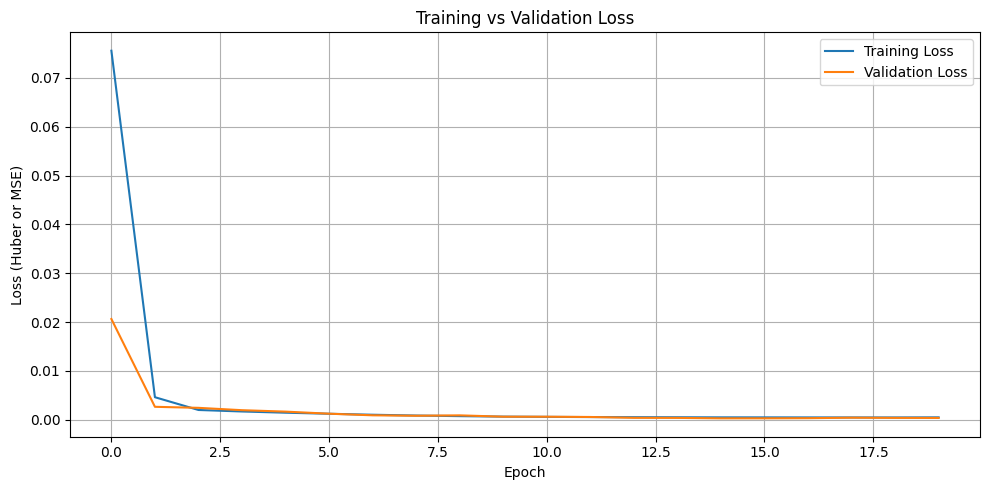

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# 建立 GRU 模型
model = Sequential()
model.add(GRU(64, input_shape=(window_size, 3)))
model.add(Dense(3))  # 三個幣種輸出
model.compile(optimizer='adam', loss='mse')

# 訓練
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  # ← 加上驗證集
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 儲存完整模型
model.save("fx_model_gru.h5")
print("模型已儲存為 fx_model_gru.h5")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber or MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/loss_curve.png")
plt.show()


***Step 3：開始做 Rolling 預測 + 驗證***

In [9]:
# 用訓練完的模型，從 day=1000 到 day=1089 做逐日預測
preds = []
true_vals = []

for i in range(train_days, len(fx_scaled) - 1):
    input_seq = fx_scaled[i - window_size:i]  # 拿前30天做預測
    input_seq = input_seq.reshape(1, window_size, 3)

    pred_scaled = model.predict(input_seq)[0]  # shape: (3,)
    true_scaled = fx_scaled[i]  # 真實第 i 天的資料

    # 還原成實際價格
    pred_real = scaler.inverse_transform([pred_scaled])[0]
    true_real = scaler.inverse_transform([true_scaled])[0]

    preds.append(pred_real)
    true_vals.append(true_real)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

***Step 4：計算誤差指標（RMSE、MAE)***

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

preds = np.array(preds)
true_vals = np.array(true_vals)

rmse = np.sqrt(mean_squared_error(true_vals, preds))
mae = mean_absolute_error(true_vals, preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


RMSE: 0.7080
MAE: 0.3192


In [11]:
import matplotlib.pyplot as plt
import os

currency_names = ['USDJPY', 'EURUSD', 'GBPUSD']

# 建立 results 資料夾（若尚未存在）
save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)

def get_unique_filename(base_name, ext='png'):
    """回傳不重複的檔案名稱（在 results 資料夾內）"""
    counter = 1
    filename = os.path.join(save_dir, f"{base_name}.{ext}")
    while os.path.exists(filename):
        filename = os.path.join(save_dir, f"{base_name}_{counter}.{ext}")
        counter += 1
    return filename

for i in range(3):
    plt.figure(figsize=(10, 4))
    plt.plot([t[i] for t in true_vals], label='True')
    plt.plot([p[i] for p in preds], label='Predicted')
    plt.title(f"Rolling Prediction - {currency_names[i]}")
    plt.xlabel("Days")
    plt.ylabel("Exchange Rate")
    plt.legend()
    plt.grid(True)

    filename = get_unique_filename(f"rolling_prediction_{currency_names[i]}")
    plt.savefig(filename)
    plt.close()
    print(f"Saved: {filename}")


Saved: results\rolling_prediction_USDJPY_11.png
Saved: results\rolling_prediction_EURUSD_11.png
Saved: results\rolling_prediction_GBPUSD_11.png
